In [3]:
# CONNECT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#importing data
import zipfile, os
local_zip = '/content/drive/My Drive/DATASET/CoffeLeaves/CoffeeDisease.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [19]:
#importing CNN library
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 60

In [21]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CoffeeDisease/Train/",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1078 files belonging to 3 classes.


In [22]:
class_names = dataset.class_names
class_names

['Healthy', 'Red_spider_mite', 'Rust']

In [23]:
len(dataset)

34

In [24]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 0 2 2 2 0 2 2 2 2 0 0 0 0 0 0 2 0 0 2 2 0 2 2 1 2 2 0 2 2 2]


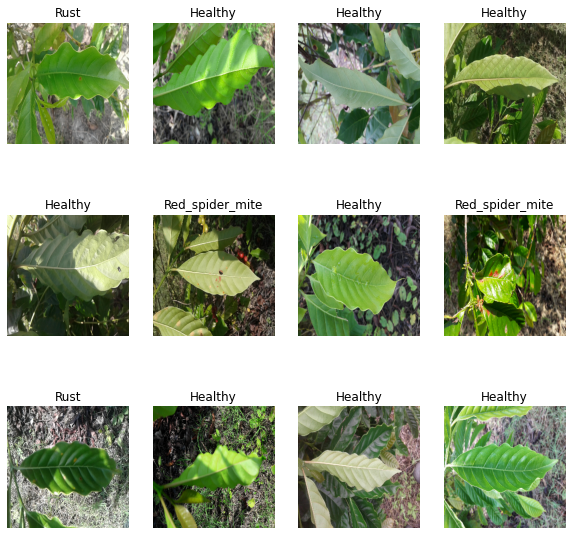

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [26]:
train_size = 0.8
len(dataset)*train_size

27.200000000000003

In [27]:
train_ds = dataset.take(23)
len(train_ds)

23

In [28]:
test_ds = dataset.skip(23)
len(test_ds)

11

In [29]:
val_size = 0.1
len(dataset)*val_size

3.4000000000000004

In [30]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [31]:
test_ds = test_ds.skip(2)
len(test_ds)

9

In [32]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [33]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [34]:
len(train_ds)

27

In [35]:
len(val_ds)

3

In [36]:
len(test_ds)

4

In [37]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [38]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [39]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [40]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [42]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/60
27/27 [==============================] - 144s 5s/step - loss: 1.0118 - accuracy: 0.4745 - val_loss: 0.9018 - val_accuracy: 0.5312
Epoch 2/60
27/27 [==============================] - 102s 4s/step - loss: 1.0168 - accuracy: 0.4630 - val_loss: 0.8782 - val_accuracy: 0.5312
Epoch 3/60
27/27 [==============================] - 103s 4s/step - loss: 0.9941 - accuracy: 0.5012 - val_loss: 0.9489 - val_accuracy: 0.5312
Epoch 4/60
27/27 [==============================] - 103s 4s/step - loss: 0.9807 - accuracy: 0.5012 - val_loss: 0.8778 - val_accuracy: 0.5312
Epoch 5/60
27/27 [==============================] - 106s 4s/step - loss: 0.9628 - accuracy: 0.5035 - val_loss: 0.8385 - val_accuracy: 0.5417
Epoch 6/60
27/27 [==============================] - 103s 4s/step - loss: 0.9644 - accuracy: 0.5058 - val_loss: 0.9067 - val_accuracy: 0.5104
Epoch 7/60
27/27 [==============================] - 101s 4s/step - loss: 0.9119 - accuracy: 0.5405 - val_loss: 0.8299 - val_accuracy: 0.5521
Epoch 8/60
27

In [44]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 31s 840ms/step - loss: 0.3772 - accuracy: 0.9153


In [45]:
scores

[0.37721502780914307, 0.9152542352676392]

In [46]:
history

In [47]:
history.params

{'epochs': 60, 'steps': 27, 'verbose': 1}

In [48]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

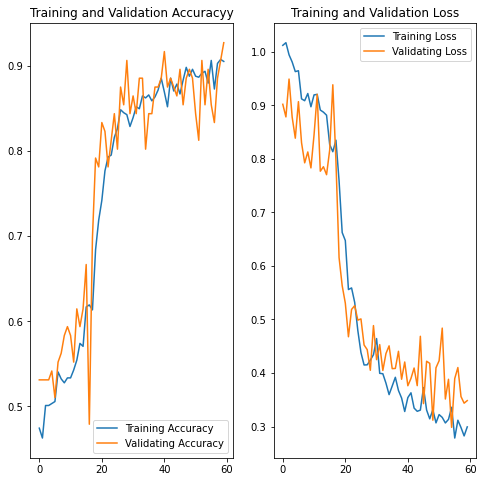

In [50]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validating Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracyy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validating Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
actual label :  Rust
predicted label :  Rust


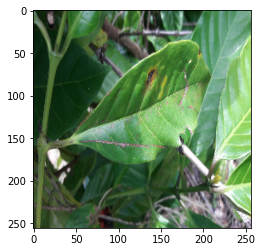

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("actual label : ",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label : ", class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

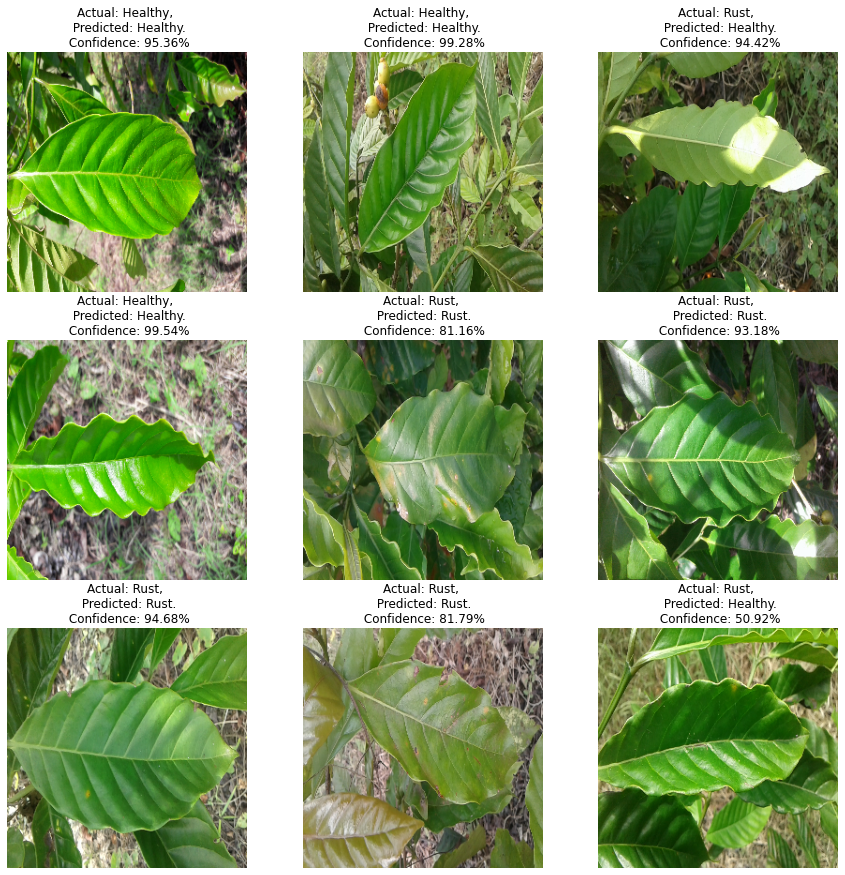

In [53]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")